## IMPORT TOOLS AND LIBRARIES

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay

from joblib import dump, load

randomseed = 15

## DATA HANDLING

##### IMPORT AND SHUFFLE DATA

In [2]:
np.random.seed(randomseed)
heartDiseaseData = pd.read_csv('heart-disease.csv')
heartDisease = pd.DataFrame(heartDiseaseData).sample(frac=1)
heartDisease = heartDisease.drop(['chol', 'fbs'], axis=1)  # REMOVE DATA THAT DOES NOT CORRELATE WITH TARGET
print(heartDisease)

     age  sex  cp  trestbps  restecg  thalach  exang  oldpeak  slope  ca  \
201   60    1   0       125        0      141      1      2.8      1   1   
197   67    1   0       125        1      163      0      0.2      1   2   
64    58    1   2       140        0      165      0      0.0      2   0   
134   41    0   1       126        1      163      0      0.0      2   0   
145   70    1   1       156        0      143      0      0.0      2   0   
..   ...  ...  ..       ...      ...      ...    ...      ...    ...  ..   
199   65    1   0       110        0      158      0      0.6      2   2   
155   58    0   0       130        1      131      0      0.6      1   0   
156   47    1   2       130        1      179      0      0.0      2   0   
133   41    1   1       110        1      153      0      0.0      2   0   
245   48    1   0       124        0      166      0      0.5      1   0   

     thal  target  
201     3       0  
197     3       0  
64      2       1  
134    

##### SPLIT DATA

In [3]:
np.random.seed(randomseed)
X = heartDisease.drop('target', axis=1)
y = heartDisease['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X)
print(y)

     age  sex  cp  trestbps  restecg  thalach  exang  oldpeak  slope  ca  thal
201   60    1   0       125        0      141      1      2.8      1   1     3
197   67    1   0       125        1      163      0      0.2      1   2     3
64    58    1   2       140        0      165      0      0.0      2   0     2
134   41    0   1       126        1      163      0      0.0      2   0     2
145   70    1   1       156        0      143      0      0.0      2   0     2
..   ...  ...  ..       ...      ...      ...    ...      ...    ...  ..   ...
199   65    1   0       110        0      158      0      0.6      2   2     1
155   58    0   0       130        1      131      0      0.6      1   0     2
156   47    1   2       130        1      179      0      0.0      2   0     2
133   41    1   1       110        1      153      0      0.0      2   0     2
245   48    1   0       124        0      166      0      0.5      1   0     3

[303 rows x 11 columns]
201    0
197    0
64     1


## TRAIN AND CONDUCT INITIAL MODEL TEST

##### CREATE FUNCTION TO TRAIN AND TEST MODELS

In [89]:
def train_test_score(models, xtrain, xtest, ytrain, ytest):

    model_accuracy = {}
    model_precision = {}
    model_recall = {}
    model_f1 = {}

    for name, model in models.items():
        print(f'Testing {name} model...')
        model.fit(xtrain, ytrain)
        ypred = model.predict(xtest)
        model_accuracy[name] = accuracy_score(ytest, ypred)
        model_precision[name] = precision_score(ytest, ypred)
        model_recall[name] = recall_score(ytest, ypred)
        model_f1[name] = f1_score(ytest, ypred)
    
    return [model_accuracy, model_precision, model_recall, model_f1]

##### INITIALISE MODELS

In [90]:
initial_models = {'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
                  'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
                  'LogisticRegression': LogisticRegression(n_jobs=-1)}
                  
print(f"{pd.DataFrame(initial_models['RandomForestClassifier'].get_params(), index=['RandomForestClassifier']).transpose()}\n")
print(f"{pd.DataFrame(initial_models['KNeighborsClassifier'].get_params(), index=['KNeighborsClassifier']).transpose()}\n")
print(f"{pd.DataFrame(initial_models['LogisticRegression'].get_params(), index=['LogisticRegression']).transpose()}\n")

                         RandomForestClassifier
bootstrap                                  True
ccp_alpha                                   0.0
class_weight                               None
criterion                                  gini
max_depth                                  None
max_features                               auto
max_leaf_nodes                             None
max_samples                                None
min_impurity_decrease                       0.0
min_samples_leaf                              1
min_samples_split                             2
min_weight_fraction_leaf                    0.0
n_estimators                                100
n_jobs                                       -1
oob_score                                 False
random_state                               None
verbose                                       0
warm_start                                False

              KNeighborsClassifier
algorithm                     auto
leaf_size        

##### TRAIN MODELS AND CONDUCT INITIAL TEST

In [91]:
initial_results = pd.DataFrame(train_test_score(initial_models, X_train, X_test, y_train, y_test), index=['Accuracy', 'Precision', 'Recall', 'F1'])

Testing RandomForestClassifier model...
Testing KNeighborsClassifier model...
Testing LogisticRegression model...


##### CREATE FUNCTION TO VISUALISE TEST RESULTS

In [92]:
def visualise_results(results):
    print(results)
    results_bar = results.plot.bar(figsize=(17, 8), xlabel='Scoring Method', ylabel='Model Score', title='Results of Models')
    results_bar.legend(title='Model Type', bbox_to_anchor=(1.01, 1));

##### VISUALISE AND COMPARE INITIAL TEST RESULTS

Initial Test Results
           RandomForestClassifier  KNeighborsClassifier  LogisticRegression
Accuracy                 0.852459              0.672131            0.885246
Precision                0.864865              0.750000            0.891892
Recall                   0.888889              0.666667            0.916667
F1                       0.876712              0.705882            0.904110


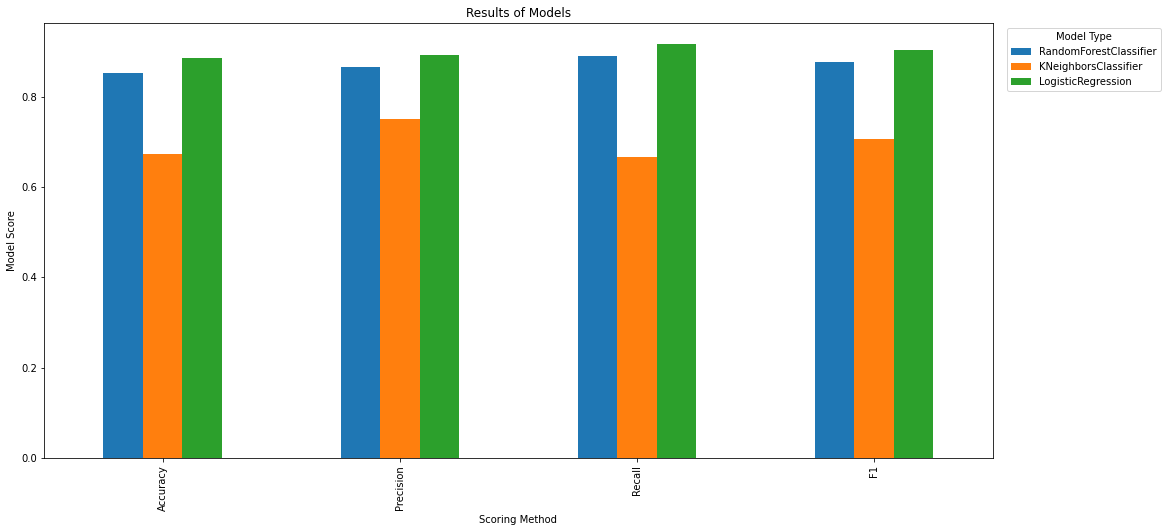

In [93]:
print('Initial Test Results')
visualise_results(initial_results)

## TUNE AND RE-TEST MODELS

##### RANDOMFOREST CLASSIFIER MODEL

In [94]:
max_depth = [n for n in range(10, 200, 10)]
max_depth.append(None)
rs_randForest_grid = {'n_estimators': [n for n in range(500, 5000, 100)],
                      'max_features': ['auto', 'sqrt'],
                      'max_depth': max_depth,
                      'min_samples_split': [n for n in range(2, 20, 2)],
                      'min_samples_leaf': [n for n in range(1, 10, 2)],
                      'bootstrap': [True, False]}
rs_randForest = RandomizedSearchCV(estimator=initial_models['RandomForestClassifier'],
                                   param_distributions=rs_randForest_grid,
                                   n_iter=10,
                                   cv=5,
                                   verbose=3,
                                   random_state=randomseed,
                                   n_jobs=-1)

##### LOGISTIC REGRESSION MODEL

In [96]:
rs_logReg_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
                  'max_iter': [n for n in range(50, 5000, 100)]}
rs_logReg = RandomizedSearchCV(estimator=initial_models['LogisticRegression'],
                               param_distributions=rs_logReg_grid,
                               n_iter=10,
                               cv=5,
                               verbose=3,
                               random_state=randomseed,
                               n_jobs=-1)

##### KNEIGHBOURS MODEL
- WILL NO LONGER BE USED AS IT SCORED TOO POORLY IN INITIAL TEST

##### INITIALISE TUNED MODELS

In [97]:
tuned_models = {'RandomForestClassifier': rs_randForest,
                'LogisticRegression': rs_logReg}

##### TRAIN AND TEST TUNED MODELS

In [98]:
tuned_results = train_test_score(tuned_models, X_train, X_test, y_train, y_test)

Testing RandomForestClassifier model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Testing LogisticRegression model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Tuned Results:
           RandomForestClassifier  LogisticRegression
Accuracy                 0.852459            0.885246
Precision                0.864865            0.891892
Recall                   0.888889            0.916667
F1                       0.876712            0.904110

Best Parameters for Models:

                  RandomForestClassifier
n_estimators                        2400
min_samples_split                     16
min_samples_leaf                       7
max_features                        sqrt
max_depth                             20
bootstrap                           True

          LogisticRegression
max_iter                  50
C                          1




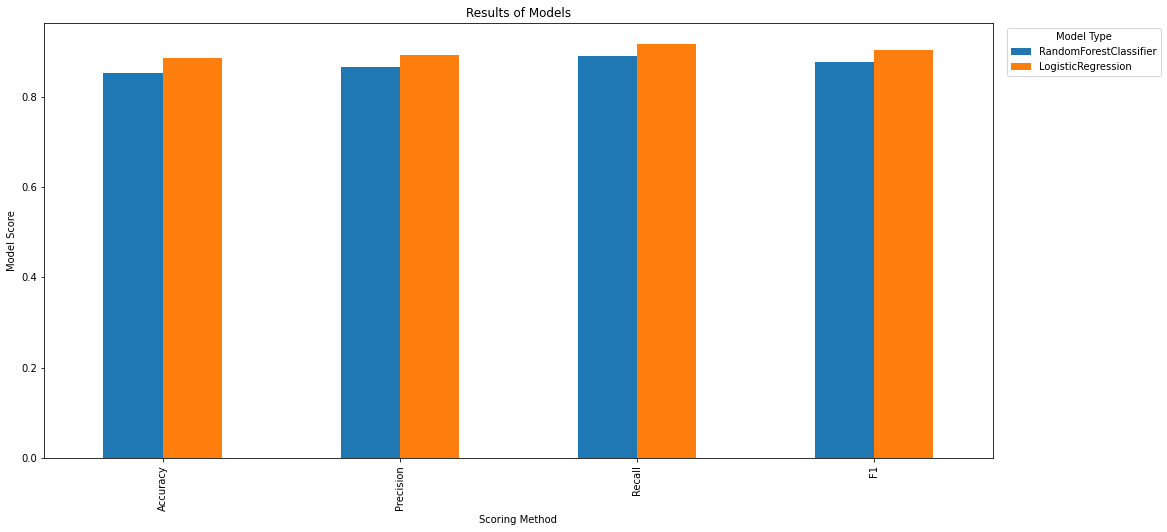

In [125]:
print('Tuned Results:')
visualise_results(pd.DataFrame(tuned_results, index=['Accuracy', 'Precision', 'Recall', 'F1']))

randForBestParams = rs_randForest.best_params_
logRegBestParams = rs_logReg.best_params_

print(f'''
Best Parameters for Models:

{pd.DataFrame(randForBestParams, index=['RandomForestClassifier']).transpose()}

{pd.DataFrame(logRegBestParams, index=['LogisticRegression']).transpose()}

''')

## FINAL TUNE AND TEST OF MODEL

##### RANDOMFOREST CLASSIFIER MODEL
- WILL NO LONGER BE USED AS LOGISTIC REGRESSION MODEL PERFORMED BETTER

##### LOGISTIC REGRESSION MODEL

In [101]:
gs_logReg_grid = {'C': [0.01, 0.5, 1, 5, 10],
                  'max_iter': [n for n in range(10, 100, 10)]}

gs_logReg = GridSearchCV(estimator=initial_models['LogisticRegression'],
                         param_grid=gs_logReg_grid,
                         cv=5,
                         verbose=3,
                         n_jobs=-1)

##### INITIALISE MODEL

In [102]:
final_model = {'LogisticRegression': gs_logReg}

##### TRAIN AND TEST MODEL

In [103]:
final_result = train_test_score(final_model, X_train, X_test, y_train, y_test)

Testing LogisticRegression model...
Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [104]:
print('Best Parameters')
print(pd.DataFrame(gs_logReg.best_params_, index=['LogisticRegression']).transpose())

Best Parameters
          LogisticRegression
C                        0.5
max_iter                40.0


## MODEL EVALUATION AND SUMMARY

##### MODEL SCORE

In [124]:
final_result = final_result[:4]
ypred = gs_logReg.predict(X_test)
model_RocAuc = {}
model_RocAuc['LogisticRegression'] = roc_auc_score(y_test, ypred)
final_result.append(model_RocAuc)
print('Final Score:')
print(pd.DataFrame(final_result, index=['Accuracy', 'Precision', 'Recall', 'F1', 'RocAuc']))

Final Score:
           LogisticRegression
Accuracy             0.885246
Precision            0.891892
Recall               0.916667
F1                   0.904110
RocAuc               0.878333


##### MODEL ROC CURVE

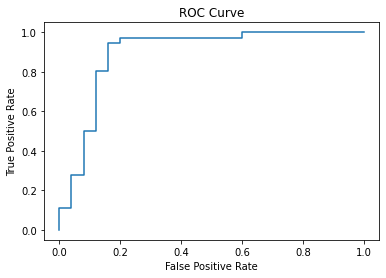

In [110]:
y_pred_proba = gs_logReg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

##### MODEL CONFUSION MATRIX

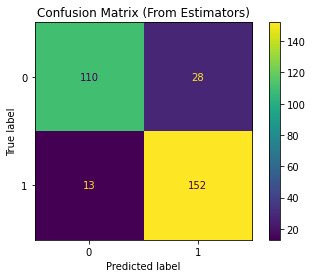

In [111]:
ConfusionMatrixDisplay.from_estimator(estimator=gs_logReg, X=X, y=y)
plt.title('Confusion Matrix (From Estimators)');

##### MODEL CLASSIFICATION REPORT

In [112]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        25
           1       0.89      0.92      0.90        36

    accuracy                           0.89        61
   macro avg       0.88      0.88      0.88        61
weighted avg       0.88      0.89      0.88        61



## SAVE AND LOAD MODEL

##### SAVE MODEL

In [128]:
dump(gs_logReg, filename='HeartDiseaseModel.joblib')

['HeartDiseaseModel.joblib']

##### LOAD MODEL

In [129]:
heartDiseaseModel = load(filename='HeartDiseaseModel.joblib')

##### ENSURE MODEL LOADED SUCCESSFULLY

In [130]:
hDModel_ypred = heartDiseaseModel.predict(X_test)
print(classification_report(y_test, hDModel_ypred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        25
           1       0.89      0.92      0.90        36

    accuracy                           0.89        61
   macro avg       0.88      0.88      0.88        61
weighted avg       0.88      0.89      0.88        61

